In [1]:
pip install pymystem3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import re
from collections import Counter
from pymystem3 import Mystem
from scipy.spatial import distance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import seaborn as sns


## Открываем данные

In [3]:
all_data = pd.read_csv('../input/mysberq/vk.csv')

In [4]:
all_data.head()

,Unnamed: 0,question,answer
0,0,кредитная карта моментум. ею можно расплачива...,"вы можете, использовать кредитую карту visa/..."
1,1,"на дебетную карту пришло сообщение о ""неразреш...",по данному вопросу вы можете обратиться в сл...
2,2,вопрос. почему не приходят смс о пополнении ка...,по данному вопросу вы можете обратиться в сл...
3,3,"есть зарплатная карта сб, пользуюсь сбол. кро...",по данному вопросу вы можете обратиться в сл...
4,4,"здраствуйте.мне пришло смс ,что одобрен предво...",потребительский кредит может быть выдан при ...


In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40117 entries, 0 to 40116
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  40117 non-null  int64 
 1   question    40082 non-null  object
 2   answer      40115 non-null  object
dtypes: int64(1), object(2)
memory usage: 940.4+ KB


In [6]:
all_data = all_data.dropna()

In [7]:
all_data = all_data.reset_index()
all_data = all_data.drop('index', axis=1)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40081 entries, 0 to 40080
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  40081 non-null  int64 
 1   question    40081 non-null  object
 2   answer      40081 non-null  object
dtypes: int64(1), object(2)
memory usage: 939.5+ KB


## Строим базовую модель

In [78]:
stopwords_list = stopwords.words('russian')

stopwords_list.extend(['//','http','«\n','»\n','https',"''\n" ])

lemmatizer = Mystem()

def my_tokenizer(doc):
    
    words = word_tokenize(doc)
    pos_tags = pos_tag(words)
    non_stopwords = [w for w in pos_tags if not w[0].lower() in stopwords_list]
    non_punctuation = [w for w in non_stopwords if not w[0] in string.punctuation]
    lemmas = []
    for w in non_punctuation:
  
        lemmas.append(lemmatizer.lemmatize(w[0])[0])

    return lemmas

/opt/conda/lib/python3.7/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/stopwords/russian'>
  return concat([self.open(f).read() for f in fileids])


In [9]:
all_data['lemmas'] = all_data['question'].apply(my_tokenizer)

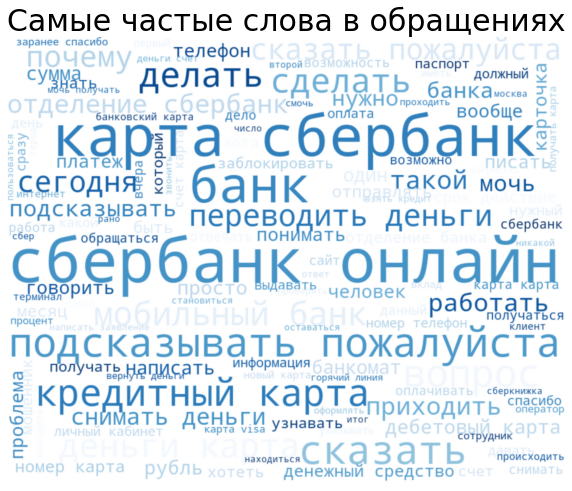

In [79]:
words = []
for i in all_data['lemmas']:
    words.extend(i)
    
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'Blues', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(",".join(words))  

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.title("Самые частые слова в обращениях",size= 30)
plt.axis("off")
plt.show()


In [11]:

most_common = Counter(words).most_common()
words, counts = zip(*most_common)
ones = counts.count(1)
most_common = Counter(words).most_common()[:ones]
words, counts = zip(*most_common)
#удалим из словаря все уникальные слова для понижения размерности

In [12]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=my_tokenizer, vocabulary=words) #не берем редкие слова встречающиеся только 1 раз
tfidf_matrix = tfidf_vectorizer.fit_transform(tuple(all_data['question']))
print(tfidf_matrix.shape)

(40081, 12183)


In [13]:
def ask_question(question):
    query_vect = tfidf_vectorizer.transform([question])
    similarity = cosine_similarity(query_vect, tfidf_matrix)
    max_similarity = np.argmax(similarity, axis=None)
    
    print('Ваш вопрос:', question)
    print('Ближайший вопрос:', all_data.iloc[max_similarity]['question'])
    print('Сходство: {:.2%}'.format(similarity[0, max_similarity]))
    print('Ответ:', all_data.iloc[max_similarity]['answer'])

In [14]:
ask_question('Почему у меня заблокировали карту?')

Ваш вопрос: Почему у меня заблокировали карту?
Ближайший вопрос: заблокировали карту. почему?
Сходство: 100.00%
Ответ:  для уточнения причин блокировки и возможности разблокировки карты рекомендуем вам обратиться в контактный центр по номеру 8-800-555-555-0.


In [15]:
ask_question('Подскажите, а есть ли отделения сбера в Крыму?')

Ваш вопрос: Подскажите, а есть ли отделения сбера в Крыму?
Ближайший вопрос: есть отделения в крыму?
Сходство: 76.87%
Ответ:  в настоящее время группа сбербанк не работает на территории автономной республики крым (ар крым) и города севастополя. решение относительно дальнейших действий пока не принято. в случае каких-либо изменений банк своевременно информирует своих клиентов.


Работает не плохо.) Но мы не можем оценить качество такой модели. И с ней есть много других проблем.

## Кластерный анализ

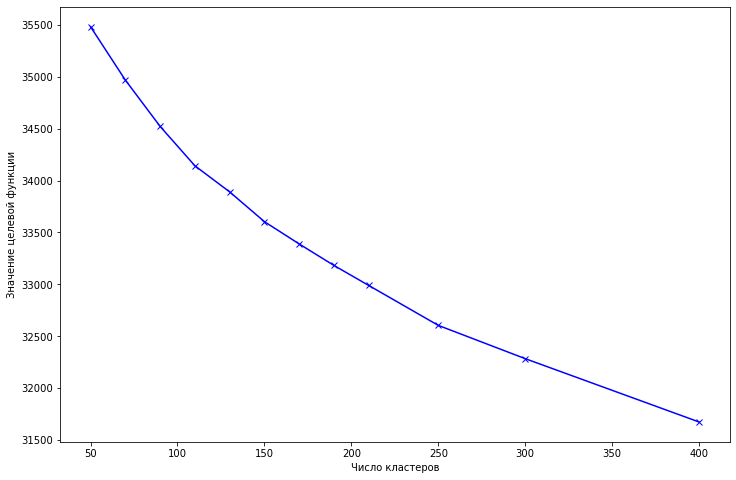

In [16]:
"""
%%time

K = (50,250,20)
distortion = []
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(matrix_df)
    print('Число кластеров:', k) 
    print('Значение целевой функции',model.inertia_)
    distortion.append(model.inertia_)
"""  
K = [50,70,90,110,130,150,170,190,210,250,300,400]
distortion = [35482.16466495755,34968.55809841195,34522.15676778185,34142.69272324206,33890.75187095296,33604.122521442834, 33389.14892999087, 33182.12732337391,32989.36115059706,32604.70163072907, 32284.136261314103,31674.03906951903]
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()


Мы возьмем количество кластеров в 250, на этой точке ускоряется падение функции. Это приемлимое число кластеров, но в дальнейшем стоило бы попробывать посомтреть как ведет себя фунекция на более дальний отрезках и найти другую точку оптимального разбиения на кластеры, где функция почти перестанет убывать стремительно. 

In [18]:
"""
%%time

model = KMeans(n_clusters=250, random_state=12345)
model.fit(matrix_df)

centroids = pd.DataFrame(model.cluster_centers_, columns=matrix_df.columns)
matrix_df['label'] =  model.labels_.astype(str)
centroids['label'] = [str(i) for i in range(250)]
print('Значение целевой функции',model.inertia_)
data_centroids = pd.concat([matrix_df, centroids], ignore_index=True)
all_data['cluster']=matrix_df['label']
all_data.to_csv('out.csv',index=False)

"""
#загрузка сохраненных данных после разбиения их на кластеры
matrix_df = tfidf_matrix.todense()
matrix_df = pd.DataFrame(matrix_df)
all_data = pd.read_csv('../input/outsave/out.csv', converters={'lemmas': eval})
all_data['cluster']=all_data['cluster'].astype(str)
matrix_df['label'] = all_data['cluster']
cluster_indexes ={str(i): i for i in range(250)}
for i in range(250):
    cluster_indexes[str(i)] = all_data[all_data['cluster']==str(i)].index
    
#сохраним индексы кластеров

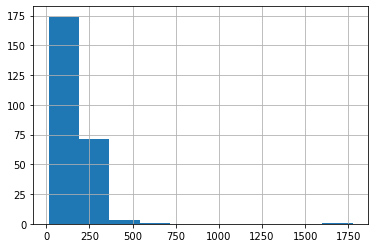

In [19]:
all_data['cluster'].value_counts().hist() #такие вот кластеры по размеру
# видим один аутлайнер 

In [20]:
all_data['cluster'].value_counts().head() #это кластер под номером три

3      1776
158     629
61      503
166     427
201     374
Name: cluster, dtype: int64

Подумаем над тем как лучше назвать кластеры.

In [21]:
# можно узнавать значение кластера рассматривая количеству слов, но нам нужно в одно слово поэтому такое не подходит
def cluster_info(number):
    words = []
    for i in all_data[all_data['cluster']==str(number)]['lemmas']:
        words.extend(i)
    most_common = Counter(words).most_common()[:20]
    return most_common
    
print(cluster_info(161))

[('визит', 17), ('карта', 11), ('банк', 10), ('отделение', 7), ('номер', 5), ('сбербанк', 5), ('мобильный', 4), ('спасибо', 4), ('оформлять', 4), ('привязывать', 3), ('вопрос', 3), ('личный', 3), ('деньги', 3), ('счет', 3), ('офис', 3), ('документ', 3), ('отключать', 2), ('адрес', 2), ('отправлять', 2), ('подсказывать', 2)]


In [22]:
#Попробуем именовать по самому весомому слову в кластере
def cluster_name(number):
    max_word = matrix_df[matrix_df['label']==str(number)].drop('label',axis=1).mean().max() # самое весомое слово в кластере
    result = np.where(matrix_df[matrix_df['label']==str(number)].drop('label',axis=1).mean() == max_word)
    result = result[0][0]
    return tfidf_vectorizer.get_feature_names()[result]

cluster_name(161) #неплохо, оно же первое слово

'визит'

In [23]:
#или по самому весомом относительно других
def cluster_name_two(number):
    mean_total_vecotr = matrix_df.drop('label',axis=1).mean()
    mean_cluster_vector = matrix_df[matrix_df['label']==str(number)].drop('label',axis=1).mean()
    meaning_vector = mean_cluster_vector - mean_total_vecotr
    interesting_value = meaning_vector.max()
    result = np.where(meaning_vector == interesting_value)
    result = result[0][0]   
    return tfidf_vectorizer.get_feature_names()[result]

cluster_name_two(161) # тот же ответ

'визит'

In [24]:
print(cluster_name(3))
print(cluster_name_two(3))

#почти всегда эти способы дают одинаковое значение, но напрмиер 3 кластер:
#сбербанк 
#адрес

сбербанк
адрес


Кстати 3 кластер это наш аутлайнер с самым большим количеством вопросов. Значит чаще всего задают вопросы по поводу адреса. Если бы мы использывали другой классификатор он бы показал Сбербанк и мы так бы и не узнали суть кластера.

Таким образом мы выяснили что лучше всего именовать классы по самому весомому слову относительно общего массива.

In [25]:
cluster_info ={str(i): i for i in range(250)}
for i in range(250):
    cluster_info[str(i)]=cluster_name_two(i)

In [26]:
clusters_pivot = pd.DataFrame(all_data['cluster'].value_counts()).reset_index().rename(columns={"index": "cluster_number","cluster": "count"})
clusters_pivot['cluster_name']= clusters_pivot['cluster_number'].apply(lambda x: cluster_info.get(str(x)) )
clusters_pivot #соберем информацию по кластерам в одну табличку

,cluster_number,count,cluster_name
0,3,1776,адрес
1,158,629,''\n
2,61,503,кредит
3,166,427,//
4,201,374,карта
...,...,...,...
245,169,20,айфон
246,15,18,реквезит
247,111,16,--\n
248,161,16,визит


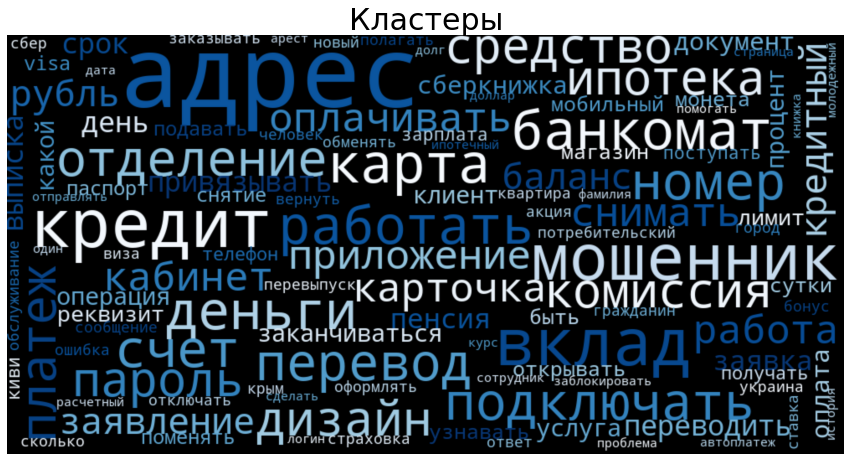

In [68]:
#Визуализация кластров по размерам
cloud = []
for i in range(len(clusters_pivot)):
    count = clusters_pivot.iloc[i]['count']
    cloud.append((clusters_pivot.iloc[i]['cluster_name']+" ")*count)

word_cloud = WordCloud(width = 1000,
                       height = 500,
                       colormap = 'Blues', 
                       margin = 0,
                       max_words = 250,  
                       min_word_length = 4,
                       collocations=False,
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "black").generate(" ".join(cloud))  

plt.figure(figsize = (15, 25))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.title("Кластеры",size= 30)
plt.axis("off")
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

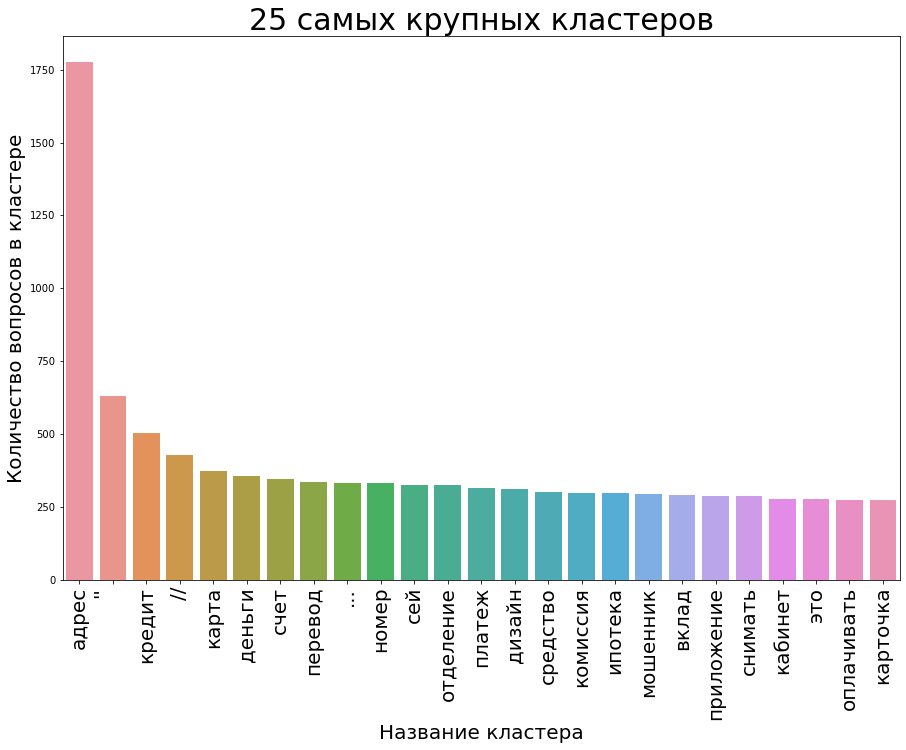

In [67]:
#25 самых крупных кластеров
fig, ax = plt.subplots(figsize=(15, 10))
b =sns.barplot(ax = ax,data = clusters_pivot.head(25), x='cluster_name', y="count", label='big')
ax.set_title("25 самых крупных кластеров",fontsize=30)
b.set_ylabel("Количество вопросов в кластере",fontsize=20)
b.set_xlabel("Название кластера",fontsize=20)
plt.xticks(rotation=90, size = 20)


Мы видим что из-за ошибки в предобработке текста у нас есть плохие кластеры: n\, //, .. .

В целом кластеры нормальные и их навзание отражает их содержание. 

## Поиск лучших ответов

Будем отвечать на вопросы таким образом: 1) сначала находим самый близакий вопрос и даем на него ответ как делали ранее 2) Находим второй в данных исключая кластер первого ответа 3) Находим третий ответ в данных исключая первые два кластера

Таким образом мы хотим получить достаточно разные вопрос-ответы что-бы охватить релевантные темы.

In [71]:
def ask_question_clusters(question, tfidf_matrix= tfidf_matrix,tfidf_vectorizer=tfidf_vectorizer,silent = False):
    query_vect = tfidf_vectorizer.transform([question])
    similarity = cosine_similarity(query_vect, tfidf_matrix)
    max_similarity = np.argmax(similarity, axis=None)
    cluster_one = all_data.iloc[max_similarity]['cluster']
    max_similarity2 = np.argmax(np.delete(similarity,cluster_indexes.get(cluster_one)), axis=None)
    cluster_two = all_data.iloc[max_similarity2]['cluster']
    max_similarity3 = np.argmax(np.delete(similarity,np.delete(similarity,cluster_indexes.get(cluster_one))), axis=None)
    cluster_three = all_data.iloc[max_similarity3]['cluster']
    
    if silent == False:
        
        print('Ваш вопрос:', question)
        print()
        print('Ближайший вопрос 1:', all_data.iloc[max_similarity]['question'])
        print('Сходство 1: {:.2%}'.format(similarity[0, max_similarity]))
        print('Ответ 1:', all_data.iloc[max_similarity]['answer'])
        print('Кластер 1:', cluster_info.get(cluster_one))
        print()
        print('Ближайший вопрос 2:', all_data.iloc[max_similarity2]['question'])
        print('Сходство 2: {:.2%}'.format(similarity[0, max_similarity2]))
        print('Ответ 2:', all_data.iloc[max_similarity2]['answer'])
        print('Кластер 2:', cluster_info.get(cluster_two))
        print()
        print('Ближайший вопрос 3:', all_data.iloc[max_similarity3]['question'])
        print('Сходство 3: {:.2%}'.format(similarity[0, max_similarity3]))
        print('Ответ 3:', all_data.iloc[max_similarity3]['answer'])
        print('Кластер 3:', cluster_info.get(cluster_three))
    
    return [cluster_one, cluster_two,cluster_three]
    

In [72]:
ask_question_clusters("Как мне разблокировать карту??")

Ваш вопрос: Как мне разблокировать карту??

Ближайший вопрос 1: как разблокировать карту?
Сходство 1: 100.00%
Ответ 1:  для уточнения возможности разблокировки карты рекомендуем вам обратиться в контактный центр банка по бесплатному номеру 8-800-555-555-0.
Кластер 1: разблокировать

Ближайший вопрос 2: а в данный момент я не смогу изменить номер?
Сходство 2: 0.00%
Ответ 2: если номер телефона был изменен, вам необходимо написать заявление в отделении банка на отключение услуги мобильный банк от предыдущего номера и подключить услугу к новому.
Кластер 2: изменять

Ближайший вопрос 3: а можно ли оформить удбо электронной? не посещяя банк ? просто времени ужасно нет, а при оформлении карты мне его забыли оформить
Сходство 3: 2.54%
Ответ 3:  к сожалению, оформление удбо в режиме онлайн не возможно. для его оформления рекомендуем обратиться в офис банка лично.
Кластер 3: оформлять


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


['160', '68', '120']

In [73]:
ask_question_clusters("Подскажите, как можно снять деньги без комиссии в Абхазии?")

Ваш вопрос: Подскажите, как можно снять деньги без комиссии в Абхазии?

Ближайший вопрос 1: есть банкомат в абхазии и какая комиссия?
Сходство 1: 81.78%
Ответ 1:  на территории абхазии нет банкоматов и офисов нашего банка. на территории другой страны наличные по карте нашего банка можно получить в офисах или банкоматах тех банков, которые работают с картами международных платежных систем visa (international) и mastercard (worldwide). возможность получения наличных можно уточнить у сотрудников стороннего банка. за проведение операции снятия наличных в стороннем банке взимается комиссия в соответствии с тарифами нашего банка 1% от суммы, но не менее 100 руб., если операция в банкомате и не менее 150 руб. - в офисе другого банка.  обратите внимание, что сторонний банк также может взимать комиссию за проведение операции по карте, размер которой необходимо уточнить у сотрудника этого банка. напоминаем, что по картам платежной системы visa international к сумме операции добавляется комиссия 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


['60', '112', '119']

In [90]:
ask_question_clusters("Что делать если банкомат съел мою карточку?")

Ваш вопрос: Что делать если банкомат съел мою карточку?

Ближайший вопрос 1: такая проблема, пришла смс об отключении мобильного банка, пошел в банкомат снять деньги,а он съел карточку, карту ни кто не блокировал, пин код всегда вводил верно,пошел в банк там никто ничего не знает. из за чего банкомат съел карточку?
Сходство 1: 58.96%
Ответ 1:  банкомат, как и любое технически сложное устройство, может дать сбой и, к сожалению, он произошел во время вашей операции. в данном случае рекомендуем обратиться в контактный центр по номеру 8-800-555-555-0 для приостановки действия карты и следовать рекомендациям специалиста.
Кластер 1: карточка

Ближайший вопрос 2:  в приложении у меня две заблокированные карты, я знаю что их можно скрыть  но вопрос в том, они когда нибудь исчезнут, или для этого нужно что то сделать  бесит просто их наличие  спасибо!
Сходство 2: 0.00%
Ответ 2:  чтобы карты перестали отображаться в системе сбербанк онлайн, необходимо закрыть их счета. для этого обратитесь в бли

['211', '213', '100']

## Тестируем модель

In [69]:
train, test = train_test_split(all_data,random_state=123, test_size=0.1)

In [70]:
#для чистоты эксперемента надо полностью обучить модель без тестовых данных в т.ч в словаре
words = []
for i in train['lemmas']:
    words.extend(i)
most_common = Counter(words).most_common()
words, counts = zip(*most_common)
ones = counts.count(1)
most_common = Counter(words).most_common()[:ones]
words, counts = zip(*most_common)

tfidf_vectorizer_train = TfidfVectorizer(tokenizer=my_tokenizer, vocabulary=words) #не берем редкие слова встречающиеся только 1 раз, как обычно
tfidf_matrix_train = tfidf_vectorizer_train.fit_transform(tuple(train['question']))

Метрика качества. Если на вопрос из тестовой выборки хотя бы один из трех предложенных кластеров совпадает с реальным кластером мы засчитываем как правильный ответ, в противном случае как ошибку.

(Важно понимать что так мы в большей степени оцениваем качество кластерного анализа, а не самих ответов.)

In [80]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

true_answers = 0

for i in test['question']:
    clusters = ask_question_clusters(i,tfidf_matrix_train,tfidf_vectorizer_train, silent = True)
    if test[test['question']==i]['cluster'].iloc[0] in clusters:
        true_answers +=1


In [89]:
print("Accuracy: ",true_answers/(len(test)))
#Accuracy:  0.02070341731105014 (на 250 кластерах)
print('Random accuracy: ', 1/(250/3))
#Random accuracy:  0.012
print('Naive accuracy: ', clusters_pivot['count'].max()/(clusters_pivot['count'].sum()/100)  )
#Naive accuracy:  4.431027169980789 (если всем давать значение самого большого кластера)

Accuracy:  0.02070341731105014
Random accuracy:  0.012
Naive accuracy:  4.431027169980789


# Вывод

### Мы можем сделать вывод что наша модель находит нужный кластер у новых вопросов почти в два раза лучше генератора случайных чисел:). на 250 кластерах. Вместе с тем эти показатели крайне малы, значит кластерный анализ нужно улучшать оптимзируя количество кластеров и для определения кластеров использывать более сложные модели. Анализ показал что кластеры разделяются хорошо, но в данном случае они достаточно общие. Надо попробывать разделить большее количество кластеров или использывать множества.